path_root/csv/info.csv
<br>path_root/infrared/
<br>path_root/microwave_precip/
<br>path_root/terra/

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import torch
import random

from petrel_client.client import Client

client = Client(conf_path="~/petreloss.conf")

In [2]:
def prepare_data(df, list_input, list_output, ratio_train, ratio_valid, ratio_test, must_in_test, random_seed=0):
    print('preparing data ...\n')
    df_filter = df[(df[[f'nonnan_ratio_{output}' for output in list_output]] >= 0.4).all(axis=1) & (df[[f'nonnan_ratio_{input}' for input in list_input]] >= 0.95).all(axis=1)]

    # 根据最值阈值筛选
    # terra不参与，在datasets用于去除异常值
    # C11重点区域nan值太多不使用；precip未使用
    dict_minmax_threshold = {
        'min_C07': [170.0,290.0],
        'min_C08': [169.0,275.0],
        'min_C09': [172.0,275.0],
        'min_C10': [174.5,280.0],
        'min_C11': [],
        'min_C12': [179.0,260.0],
        'min_C13': [170.0,280.0],
        'min_C14': [170.0,300.0],
        'min_C15': [170.0,300.0],
        'min_C16': [170.0,280.0],
        'min_terra': [],#[0.0,4.0],
        'min_pct37': [120.0,310.0],
        'min_pct89': [50.0,300.0],
        'min_precip': [],
        'max_C07': [280.0,360.0],
        'max_C08': [225.0,330.0],
        'max_C09': [235.0,330.0],
        'max_C10': [244.0,290.4],
        'max_C11': [],
        'max_C12': [230.0,284.5],
        'max_C13': [235.0,325.0],
        'max_C14': [180.0,325.0],
        'max_C15': [280.0,320.0],
        'max_C16': [210.0,300.0],
        'max_terra': [],#[0,8849],
        'max_pct37': [280.0,360.0],
        'max_pct89': [280.0,340.0],
        'max_precip': [],
    }
    for key, value in dict_minmax_threshold.items():
        if len(value) == 2:
            df_filter = df_filter[(df_filter[key] >= value[0]) & (df_filter[key] <= value[1])]

    basin_list = df_filter['basin'].tolist()
    cyclone_number_list = df_filter['cyclone_number'].tolist()
    cyclone_number_list = [str(num).zfill(2) for num in cyclone_number_list]
    season_list = df_filter['season'].tolist()
    ATCF_ID_list = [f'{basin}{num}{season}' for basin, num, season in zip(basin_list, cyclone_number_list, season_list)]
    df_filter['ATCF_ID'] = ATCF_ID_list
    ATCF_ID_list = df_filter['ATCF_ID'].unique().tolist()
    np.random.seed(random_seed)
    np.random.shuffle(ATCF_ID_list)

    ATCF_ID_list_test = [ATCF_ID for ATCF_ID in must_in_test if ATCF_ID in ATCF_ID_list]
    ATCF_ID_list = [ATCF_ID for ATCF_ID in ATCF_ID_list if ATCF_ID not in must_in_test]

    ATCF_ID_counts = df_filter['ATCF_ID'].value_counts().loc[ATCF_ID_list]

    num_samples = len(df_filter)
    num_train = int(num_samples * ratio_train)
    num_valid = int(num_samples * ratio_valid)
    num_test = int(num_samples * ratio_test)

    ATCF_ID_list_train = []
    ATCF_ID_list_valid = []
    num_samples_accumulated = 0
    my_levels = df_filter['my_level'].unique()
    my_level_counts = {my_level: { 'train': 0, 'valid': 0, 'test': 0 } for my_level in my_levels}
    for ATCF_ID in ATCF_ID_list:
        num_samples_ATCF_ID = ATCF_ID_counts[ATCF_ID]
        my_level = df_filter[df_filter['ATCF_ID'] == ATCF_ID]['my_level'].iloc[0]
        if num_samples_accumulated < num_train or my_level_counts[my_level]['train'] == 0:
            ATCF_ID_list_train.append(ATCF_ID)
            my_level_counts[my_level]['train'] += num_samples_ATCF_ID
        elif num_samples_accumulated < num_train + num_valid or my_level_counts[my_level]['valid'] == 0:
            ATCF_ID_list_valid.append(ATCF_ID)
            my_level_counts[my_level]['valid'] += num_samples_ATCF_ID
        elif num_samples_accumulated < num_train + num_valid + num_test or my_level_counts[my_level]['test'] == 0:
            ATCF_ID_list_test.append(ATCF_ID)
            my_level_counts[my_level]['test'] += num_samples_ATCF_ID
        num_samples_accumulated += num_samples_ATCF_ID

    df_grouped_by_ATCF_ID_level_train = df_filter[df_filter['ATCF_ID'].isin(ATCF_ID_list_train)].groupby('my_level').size()
    df_grouped_by_ATCF_ID_level_valid = df_filter[df_filter['ATCF_ID'].isin(ATCF_ID_list_valid)].groupby('my_level').size()
    df_grouped_by_ATCF_ID_level_test = df_filter[df_filter['ATCF_ID'].isin(ATCF_ID_list_test)].groupby('my_level').size()
    df_grouped_by_ATCF_ID_level = pd.concat([df_grouped_by_ATCF_ID_level_train, df_grouped_by_ATCF_ID_level_valid, df_grouped_by_ATCF_ID_level_test], axis=1)
    df_grouped_by_ATCF_ID_level.columns = ['Train', 'Valid', 'Test']
    df_grouped_by_ATCF_ID_level = df_grouped_by_ATCF_ID_level.transpose()
    df_grouped_by_ATCF_ID_level = df_grouped_by_ATCF_ID_level.fillna(0).astype(int)
    df_grouped_by_ATCF_ID_level['Total'] = df_grouped_by_ATCF_ID_level.sum(axis=1)
    df_grouped_by_ATCF_ID_level.loc['Total'] = df_grouped_by_ATCF_ID_level.sum()
    df_grouped_by_ATCF_ID_level = df_grouped_by_ATCF_ID_level.reindex(columns=['TD', 'TS', 'C1', 'C2', 'C3', 'C4', 'C5', 'Total'])

    print(f'{df_grouped_by_ATCF_ID_level}\n')

    set_train = set(ATCF_ID_list_train)
    set_valid = set(ATCF_ID_list_valid)
    set_test = set(ATCF_ID_list_test)
    print(f'ATCF_ID_list_train ∩ valid: {set_train & set_valid}')
    print(f'ATCF_ID_list_train ∩ test: {set_train & set_test}')
    print(f'ATCF_ID_list_valid ∩ test: {set_valid & set_test}')
    print(f'ATCF_ID_list_test includes ATCF ID in must_in_test: {set(must_in_test) <= set(ATCF_ID_list_test)}\n')

    # 从df_filter根据ATCF_ID_list_train、ATCF_ID_list_valid和ATCF_ID_list_test构建df_train、df_valid和df_test
    df_train = df_filter[df_filter['ATCF_ID'].isin(ATCF_ID_list_train)]
    df_valid = df_filter[df_filter['ATCF_ID'].isin(ATCF_ID_list_valid)]
    df_test = df_filter[df_filter['ATCF_ID'].isin(ATCF_ID_list_test)]
    df_train.reset_index(drop=True, inplace=True)
    df_valid.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    dict_min = {f'min_{var}': df_train[f'min_{var}'].min() for var in list_input + list_output + ['precip', 'terra']}
    dict_max = {f'max_{var}': df_train[f'max_{var}'].max() for var in list_input + list_output + ['precip', 'terra']}

    print('min:')
    for key, value in dict_min.items():
        print(f'{key}: {value:.3f}')
    print('\nmax:')
    for key, value in dict_max.items():
        print(f'{key}: {value:.3f}')
    print()
    
    return df_train, df_valid, df_test, dict_min, dict_max

In [3]:
def get_filelist(df, path_root):
    
    path_ir_list, path_pctprecip_list, path_terra_list = [], [], []
    
    basin_list = df['basin'].tolist()
    cyclone_number_list = df['cyclone_number'].tolist()
    cyclone_number_list = [str(num).zfill(2) for num in cyclone_number_list]
    season_list = df['season'].tolist()

    instrument_name_list = df['instrument_name'].tolist()
    platform_name_list = df['platform_name'].tolist()

    time_list = df['time'].tolist()

    my_level_list = df['my_level'].tolist()

    for i in range(len(time_list)):

        time_pmw_str = datetime.strptime(time_list[i], '%Y-%m-%d %H:%M:%S')
        time_pmw_str = datetime.strftime(time_pmw_str, '%Y%m%d%H%M%S')

        ATCF_ID = f'{basin_list[i]}{cyclone_number_list[i]}{season_list[i]}'

        for instrument_platform in ['AHI_Himawari8', 'ABI_GOESwest', 'ABI_GOESeast']:
            path_ir = f'{path_root}/infrared/{season_list[i]}/{ATCF_ID}/{my_level_list[i]}/{ATCF_ID}_{instrument_platform}_{time_pmw_str}.npz'
            if os.path.exists(path_ir):
                break
        path_pctprecip = f'{path_root}/microwave_precip/{season_list[i]}/{ATCF_ID}/{my_level_list[i]}/{ATCF_ID}_{instrument_name_list[i]}_{platform_name_list[i]}_{time_pmw_str}.npz'
        path_terra = f'{path_root}/terra/{season_list[i]}/{ATCF_ID}/{my_level_list[i]}/{ATCF_ID}_{time_pmw_str}.npz'
        
        path_ir_list.append(path_ir); path_pctprecip_list.append(path_pctprecip); path_terra_list.append(path_terra)
        
    return path_ir_list, path_pctprecip_list, path_terra_list

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,
                dataset_type,
                list_input, list_output,
                filelist_ir, filelist_terra, filelist_pctprecip,
                patch_size,
                dict_min, dict_max,
                need_terra=True,
                sea_value=-1000,
                fill_value=0,):
        self.dataset_type = dataset_type
        self.list_input, self.list_output = list_input, list_output
        self.filelist_ir, self.filelist_terra, self.filelist_pctprecip = filelist_ir, filelist_terra, filelist_pctprecip
        self.patch_size = patch_size
        self.min, self.max = dict_min, dict_max
        self.need_terra = need_terra
        self.sea_value = sea_value
        self.fill_value = fill_value
    
    def normalize(self, data, data_min, data_max):
        normalized = np.where(data_min == data_max, 0, (data - data_min) / (data_max - data_min + 1e-7))
        normalized = np.clip(normalized, 0, 1)
        return normalized
    
    def get_patch(self, dict_vars):
        ix = random.randrange(256 - self.patch_size + 1)
        iy = random.randrange(256 - self.patch_size + 1)
        return {
            'conditions': dict_vars['conditions'][:, iy:iy + self.patch_size, ix:ix + self.patch_size],
            'labels': dict_vars['labels'][:, iy:iy + self.patch_size, ix:ix + self.patch_size],
            'mask': dict_vars['mask'][:, iy:iy + self.patch_size, ix:ix + self.patch_size],
        }

    def __len__(self):
        return len(self.filelist_ir)

    def __getitem__(self, index):
        
        # 加载原数据
        # path = f"s3://sevir_pair/{variable}/{event_time}/{event}.npy"
        npz_ir = np.load(io.BytesIO(client.get(self.filelist_ir[index])), allow_pickle=True)
        npz_terra = np.load(io.BytesIO(client.get(self.filelist_terra[index])), allow_pickle=True)
        npz_pctprecip = np.load(io.BytesIO(client.get(self.filelist_pctprecip[index])), allow_pickle=True)
        # 加载inputs到字典
        inputs = {}
        for input_name in self.list_input + ['terra']:
            if input_name not in ['terra', 'precip']:
                inputs[input_name] = -npz_ir[input_name].reshape(1, 256, 256)
            else:
                inputs['terra'] = npz_terra['terra'].reshape(1, 256, 256)
        # 加载labels到字典
        labels = {}
        for output_name in self.list_output:
            labels[output_name] = -npz_pctprecip[output_name].reshape(1, 256, 256)
        # 关闭原数据
        npz_ir.close(); npz_terra.close(); npz_pctprecip.close()
        
        # 处理input_terra
        if not np.isnan(inputs['terra']).all() and np.nanmin(inputs['terra']) > 4:
            inputs['terra'] = np.ones_like(inputs['terra']) * self.sea_value
        inputs['terra'][np.isnan(inputs['terra'])] = self.sea_value
        
        # 处理验证集和测试集异常值
        if self.dataset_type != 'train':
            # 小于最小值和大于最大值的设为nan
            for input_name in self.list_input:
                inputs[input_name][(-inputs[input_name] < self.min['min_' + input_name]) | (-inputs[input_name] > self.max['max_' + input_name])] = np.nan
            for output_name in self.list_output:
                labels[output_name][(-labels[output_name] < self.min['min_' + output_name]) | (-labels[output_name] > self.max['max_' + output_name])] = np.nan
        
        # mask记录nan的值位置
        mask = np.isnan(inputs[self.list_input[0]])
        for input_name in self.list_input[1:] + ['terra']:
            mask = mask | np.isnan(inputs[input_name])
        for output_name in self.list_output:
            mask = mask | np.isnan(labels[output_name])
        
        # 处理成同样的nan分布
        for input_name in self.list_input + ['terra']:
            #inputs[input_name][mask] = np.nan
            if input_name not in ['terra', 'precip']:
                inputs[input_name] = self.normalize(inputs[input_name], -self.max['max_' + input_name], -self.min['min_' + input_name])
            elif input_name == 'terra':
                inputs[input_name] = self.normalize(inputs[input_name], self.sea_value, self.max['max_' + input_name])
            elif input_name == 'precip':
                inputs[input_name] = self.normalize(inputs[input_name], self.min['min_' + input_name], self.max['max_' + input_name])
            inputs[input_name] = np.nan_to_num(inputs[input_name], nan=self.fill_value)
        for output_name in self.list_output:
            #labels[output_name][mask] = np.nan
            labels[output_name] = self.normalize(labels[output_name], -self.max['max_' + output_name], -self.min['min_' + output_name])
            labels[output_name] = np.nan_to_num(labels[output_name], nan=self.fill_value)
        
        # mask转换为数值（nan值位置为0，其他为1）
        mask = np.where(mask, 0, 1)
        
        mask_tensor = torch.from_numpy(mask).float()
        inputs_tensor = torch.from_numpy(np.concatenate(list(inputs.values()), axis=0)).float()
        inputs_tensor = torch.cat([mask_tensor.reshape(1, 256, 256), inputs_tensor], dim=0)
        labels_tensor = torch.from_numpy(np.concatenate(list(labels.values()), axis=0)).float()        
        
        if self.need_terra:
            return self.get_patch({
                'conditions': inputs_tensor,
                'labels': labels_tensor,
                'mask': mask_tensor,
            })
        else:
            return self.get_patch({
                'conditions': inputs_tensor[:-1],
                'labels': labels_tensor,
                'mask': mask_tensor,
            })

In [13]:
# path_root = '/mnt/petrelfs/zhaoxiangyu1/data/'

path_root = 's3://lzr_satellite'

list_input = ['C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'C15', 'C16']
list_output = ['pct37', 'pct89']
ratio_train, ratio_valid, ratio_test = 0.6, 0.2, 0.2 # as you need
must_in_test = [] # ATCF ID str list
random_seed = 0 # just keep result same each time

df = pd.read_csv(f'/mnt/petrelfs/zhaoxiangyu1/data/csv/info.csv')
df_train, df_valid, df_test, dict_min, dict_max = prepare_data(df, list_input, list_output, ratio_train, ratio_valid, ratio_test, must_in_test, random_seed)

path_ir_list_test,  path_pctprecip_list_test,  path_terra_list_test  = get_filelist(df_valid, path_root)
print(path_ir_list_test[0])

preparing data ...

my_level    TD    TS    C1   C2   C3   C4   C5  Total
Train     2907  3281   786  448  331  318   82   8153
Valid      942  1072   272  127  120  112   46   2691
Test       905  1120   257  169  129   91   32   2703
Total     4754  5473  1315  744  580  521  160  13547

ATCF_ID_list_train ∩ valid: set()
ATCF_ID_list_train ∩ test: set()
ATCF_ID_list_valid ∩ test: set()
ATCF_ID_list_test includes ATCF ID in must_in_test: True

min:
min_C07: 172.752
min_C08: 172.197
min_C09: 172.296
min_C10: 175.511
min_C12: 179.553
min_C13: 175.560
min_C14: 176.295
min_C15: 174.172
min_C16: 170.838
min_pct37: 138.643
min_pct89: 54.002
min_precip: 0.000
min_terra: 0.000

max:
max_C07: 359.456
max_C08: 324.413
max_C09: 316.124
max_C10: 290.336
max_C12: 284.381
max_C13: 318.761
max_C14: 317.384
max_C15: 319.212
max_C16: 299.252
max_pct37: 350.559
max_pct89: 320.947
max_precip: 147.140
max_terra: 7891.156

s3://lzr_satellite/infrared/2015/WP102015/TS/WP102015_ABI_GOESeast_20150707051907.n

example to load a dataset

In [43]:
dataset_test = MyDataset(
    dataset_type='train',
    list_input=list_input,
    list_output=list_output,
    filelist_ir=path_ir_list_test,
    filelist_terra=path_terra_list_test,
    filelist_pctprecip=path_pctprecip_list_test,
    patch_size=256,
    dict_min=dict_min,
    dict_max=dict_max,
    need_terra=True,
    sea_value=-1000,
    fill_value=0,
)

In [44]:
dataset_test.__len__()

2691

conditions: torch.Size([11, 256, 256]), labels: torch.Size([2, 256, 256]), mask: torch.Size([1, 256, 256])


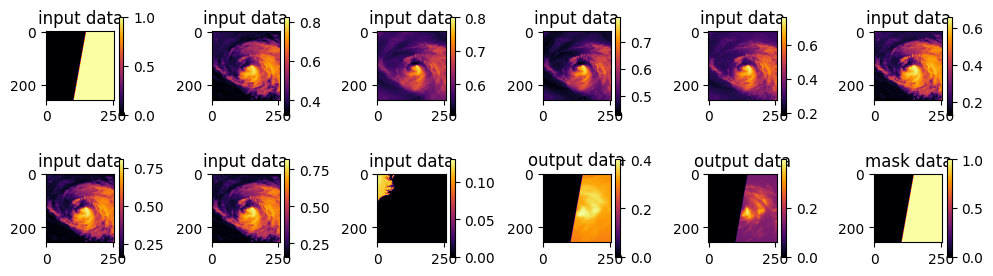

In [32]:
index = 668 # as you need
test = dataset_test[index]
inputs, labels, mask = test['conditions'], test['labels'], test['mask']
print(f'conditions: {inputs.shape}, labels: {labels.shape}, mask: {mask.shape}')
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.subplot(2, 6, 1)
plt.imshow(inputs[0], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 2)
plt.imshow(inputs[1], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 3)
plt.imshow(inputs[2], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 4)
plt.imshow(inputs[3], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 5)
plt.imshow(inputs[4], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 6)
plt.imshow(inputs[5], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 7)
plt.imshow(inputs[6], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 8)
plt.imshow(inputs[7], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 9)
plt.imshow(inputs[10], cmap='inferno')
plt.title('input data')
plt.colorbar()

plt.subplot(2, 6, 10)
plt.imshow(labels[0], cmap='inferno')
plt.title('output data')
plt.colorbar()

plt.subplot(2, 6, 11)
plt.imshow(labels[1], cmap='inferno')
plt.title('output data')
plt.colorbar()

plt.subplot(2, 6, 12)
plt.imshow(mask[0], cmap='inferno')
plt.title('mask data')
plt.colorbar()

plt.tight_layout()
plt.show()